# Data loading

In [2]:
import os
import pprint
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lifelines.utils import concordance_index, k_fold_cross_validation
from lifelines import CoxPHFitter, WeibullAFTFitter
from lifelines import KaplanMeierFitter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.utils import resample

from preprocess import get_data
import argparse

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import Formula 
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

def get_r_df(y_tr):
    with localconverter(ro.default_converter + pandas2ri.converter):
        r_y_tr = ro.conversion.py2rpy(y_tr)
    return r_y_tr

# import everything needed
r_glmnet = importr('glmnet')
r_surv = importr('survival')
base = importr('base')
utils = importr('utils')
r_stats = importr('stats')
r_graphics = importr('graphics')
r_matrix = importr('Matrix')
r_pec = importr('pec')

# call risk scores from python
with open('comparison_risk_scores.R', 'r') as fin:
    string = fin.read()
r_risk_scores = SignatureTranslatedAnonymousPackage(string, "r_risk_scores")
# added for variable control
survival_estimator_name = 'glmnet_cox'  # for this file
parser = argparse.ArgumentParser(description='risk score for pn')
parser.add_argument('--outcome', default="deceased", action="store")
parser.add_argument('--cvglmnet', action="store_true")
parser.add_argument('--prefix', default="any", action="store")
parser.add_argument('--day', type=int, default=2, action="store")
parser.add_argument('--impute', type=int, default=-1, action="store")
parser.add_argument('--seed', type=int, default=499, action="store")
parser.add_argument('--alpha', type=float, default=1.0, action="store")
parser.add_argument('--cross_val_n_folds', type=int, default=5, action="store")
parser.add_argument('--output_dir', default="output", action="store")
args = parser.parse_args("")

outcome = args.outcome
prefix = args.prefix
day = args.day
impute = args.impute  # use MissForest
seed = args.seed

d = get_data(seed=seed, prefix=prefix, day=day, impute=impute, outcome=outcome, save=True, force=False)

X_tr = d['X_train']
y_tr = d['y_train']
X_te_eicu = d['X_test_eicu']
y_te_eicu = d['y_test_eicu']
X_te_mimic = d['X_test_mimic']
y_te_mimic = d['y_test_mimic']
X_eicu_viral = d['X_eicu_viral']
y_eicu_viral = d['y_eicu_viral']
X_mimic_viral = d['X_mimic_viral']
y_mimic_viral = d['y_mimic_viral']

def combine_Xy(X, y):
    dataset = X.copy()
    for col in y.columns:
        dataset.loc[:, col] = y[col].tolist()
    return dataset

tr_dataset = combine_Xy(X_tr, y_tr)
te_eicu_dataset = combine_Xy(X_te_eicu, y_te_eicu)
te_mimic_dataset = combine_Xy(X_te_mimic, y_te_mimic)
eicu_viral_dataset = combine_Xy(X_eicu_viral, y_eicu_viral)
mimic_viral_dataset = combine_Xy(X_mimic_viral, y_mimic_viral)

tr_dataset.describe()
print('X_tr size:', X_tr.shape)


duration_col = y_tr.columns[0]
event_col = y_tr.columns[1]
print(duration_col, event_col)

def get_glmnet_params(l1_ratio, penalizer):
    l2_coeff = 0.5 * penalizer * (1 - l1_ratio)
    l1_coeff = 0.5 * penalizer * l1_ratio
    ratio = l2_coeff / l1_coeff
    alpha = 1.0 / (ratio * 2 + 1)
    lmbda = l1_coeff / alpha
    return alpha, lmbda

def get_lifelines_params(alpha, lmbda):
    l2_coeff = lmbda * (1 - alpha) / 2.0
    l1_coeff = lmbda * alpha
    ratio = l2_coeff / l1_coeff
    l1_ratio = 1.0 / (ratio + 1)
    penalizer = l1_coeff * 2 / l1_ratio
    return l1_ratio, penalizer

any_day2_deceased_seed499.pkl
file: ../data/missforest/any_day2_deceased_seed499.pkl
loaded from to ../data/missforest/any_day2_deceased_seed499.pkl


# Run our model with the best Penalty level from Grid Search
(0.01 when fitting Cox-Lasso using the glmnet package from R, which is equivalent to 0.02 when using the CoxPHFitters from the Python lifelines package)

In [12]:
best_ps = [0.02]
    
print('best penalties:', best_ps)
def get_concordances(cph, X_tr, y_tr, X_eicu, y_eicu, X_mimic, y_mimic, 
                     X_eicu_viral, y_eicu_viral, X_mimic_viral, y_mimic_viral):
    pred_tr = cph.predict_partial_hazard(X_tr)
    pred_eicu = cph.predict_partial_hazard(X_eicu)
    pred_mimic = cph.predict_partial_hazard(X_mimic)
    pred_eviral=  cph.predict_partial_hazard(X_eicu_viral)
    pred_mviral=  cph.predict_partial_hazard(X_mimic_viral)
    
    c_tr = concordance_index(y_tr[duration_col], -pred_tr, y_tr[event_col])
    c_eicu = concordance_index(y_eicu[duration_col], -pred_eicu, y_eicu[event_col])
    c_mimic = concordance_index(y_mimic[duration_col], -pred_mimic, y_mimic[event_col])
    c_eviral = concordance_index(y_eicu_viral[duration_col], -pred_eviral, y_eicu_viral[event_col])
    c_mviral = concordance_index(y_mimic_viral[duration_col], -pred_mviral, y_mimic_viral[event_col])
    return c_tr, c_eicu, c_mimic, c_eviral, c_mviral

plot_path = "plot"
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

cph_results = []
best_cphs = []
figures = []
l = 1.0
p = best_ps[0]
best_params = {"l1_ratio":l, "penalizer":p}
best_cph = CoxPHFitter(**best_params)
best_cph.fit(tr_dataset, duration_col=
             duration_col, event_col=event_col, step_size=0.15)
ctr, ceicu, cmimic, ceviral, cmviral = get_concordances(best_cph,X_tr, y_tr, X_te_eicu, y_te_eicu, X_te_mimic, y_te_mimic,
                                                       X_eicu_viral, y_eicu_viral, X_mimic_viral, y_mimic_viral)
summary = {
    "l1_ratio":l, 
    "penalizer":p,
    "C_train": ctr,
    "C_eicu:":ceicu,
    "C_mimic":cmimic,
    "C_eviral": ceviral,
    "C_mviral": cmviral,
}
cph_results.append(summary)
best_cphs.append(best_cph)
plt.rcParams['figure.figsize'] = [5, 10]
fig = best_cph.plot()
figures.append(fig)
plt.savefig("{}/coefficients_{}_l1_{}_p_{}.png".format(plot_path,tag, l, p))
plt.close()
        

best penalties: [0.02]


## Best Model Penalty: 0.02
## C-index

In [13]:
idx=0
cph_results[idx]

{'l1_ratio': 1.0,
 'penalizer': 0.02,
 'C_train': 0.7665298241757191,
 'C_eicu:': 0.7689843104872006,
 'C_mimic': 0.6553385817947497,
 'C_eviral': 0.9503105590062112,
 'C_mviral': 0.5347222222222222}

## Coefficients

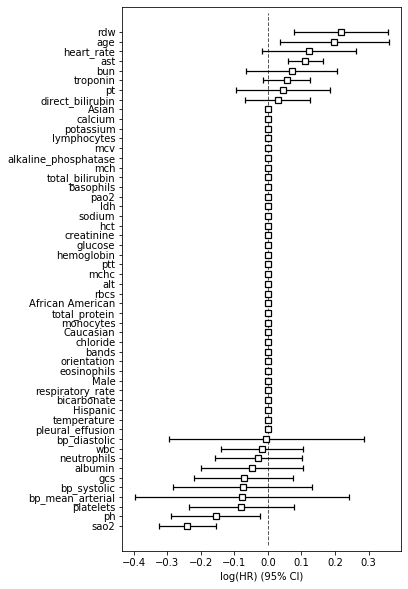

In [14]:
figures[idx].figure

In [76]:
coef_vals = best_cph.summary['coef'].tolist()
coef_lower = best_cph.summary['coef lower 95%'].tolist()
coef_upper = best_cph.summary['coef upper 95%'].tolist()

def smarter_round(sig):
    def rounder(x):
        offset = sig - floor(log10(abs(x)))
        initial_result = round(x, offset)
        if str(initial_result)[-1] == '5' and initial_result == x:
            return round(x, offset - 2)
        else:
            return round(x, offset - 1)
    return rounder

scaled_coef = {}
coef_summ = {}
dg = 5
for (c, v, l, u) in zip(best_cph.summary.index.tolist(), coef_vals, coef_lower, coef_upper):
    if c not in coefs:
        continue
    coef_summ[c] = '%.2g (%.2g - %.2g)' % (v, l, u)
    if c in scales:
        v = scales[c] * v
        l = scales[c] * l
        u = scales[c] * u
    scaled_coef[c] = '%.2g (%.2g - %.2g)' % (v, l, u)
    
coef_summ = pd.DataFrame({'Feature': coefs, 
                          'beta for normalized (95\% CI)': list([coef_summ[c] for c in coefs]),
                          'beta (95\% CI)': list([scaled_coef[c] for c in coefs]),
                          'train eICU': [round(v, 2) for v in tr_miss], 
                          'test eICU': [round(v, 2) for v in eicu_miss], 
                          'MIMIC': [round(v, 2) for v in mimic_miss]})
coef_summ = coef_summ.round(3)
print(coef_summ.to_latex(index=False))

coef_summ

\begin{tabular}{lllrrr}
\toprule
          Feature & beta for normalized (95\textbackslash \% CI) &                beta (95\textbackslash \% CI) &  train eICU &  test eICU &  MIMIC \\
\midrule
 wbc &  -0.016 (-0.14 - 0.11) &  -0.0018 (-0.016 - 0.012) &  0.01 &  0.01 &  0.01 \\
 platelets &  -0.079 (-0.24 - 0.077) &  -0.00074 (-0.0022 - 0.00072) &  0.02 &  0.02 &  0.01 \\
 rdw &  0.22 (0.078 - 0.36) &  0.088 (0.032 - 0.14) &  0.07 &  0.07 &  0.01 \\
 neutrophils &  -0.028 (-0.16 - 0.1) &  -0.0022 (-0.012 - 0.0079) &  0.24 &  0.26 &  0.15 \\
 bun &  0.071 (-0.065 - 0.21) &  0.0036 (-0.0033 - 0.011) &  0.01 &  0.01 &  0.01 \\
 ph &  -0.16 (-0.29 - -0.023) &  -2.2 (-4 - -0.33) &  0.33 &  0.35 &  0.10 \\
 direct\_bilirubin &  0.029 (-0.067 - 0.13) &  0.036 (-0.082 - 0.15) &  0.83 &  0.83 &  0.82 \\
 albumin &  -0.047 (-0.2 - 0.1) &  -0.074 (-0.31 - 0.16) &  0.17 &  0.19 &  0.28 \\
 pt &  0.044 (-0.096 - 0.18) &  0.0065 (-0.014 - 0.027) &  0.44 &  0.42 &  0.04 \\
 ast &  0.11 (0.061 - 0.16) 

,Feature,beta for normalized (95\% CI),beta (95\% CI),train eICU,test eICU,MIMIC
0,wbc,-0.016 (-0.14 - 0.11),-0.0018 (-0.016 - 0.012),0.01,0.01,0.01
1,platelets,-0.079 (-0.24 - 0.077),-0.00074 (-0.0022 - 0.00072),0.02,0.02,0.01
2,rdw,0.22 (0.078 - 0.36),0.088 (0.032 - 0.14),0.07,0.07,0.01
3,neutrophils,-0.028 (-0.16 - 0.1),-0.0022 (-0.012 - 0.0079),0.24,0.26,0.15
4,bun,0.071 (-0.065 - 0.21),0.0036 (-0.0033 - 0.011),0.01,0.01,0.01
5,ph,-0.16 (-0.29 - -0.023),-2.2 (-4 - -0.33),0.33,0.35,0.10
6,direct_bilirubin,0.029 (-0.067 - 0.13),0.036 (-0.082 - 0.15),0.83,0.83,0.82
7,albumin,-0.047 (-0.2 - 0.1),-0.074 (-0.31 - 0.16),0.17,0.19,0.28
8,pt,0.044 (-0.096 - 0.18),0.0065 (-0.014 - 0.027),0.44,0.42,0.04
9,ast,0.11 (0.061 - 0.16),0.00014 (7.9e-05 - 0.00021),0.18,0.21,0.22


## Missingness percentage for nonzero coefficients

In [41]:
from preprocess import load_csv
i=0
cph = best_cphs[i]
eicu_tr_df, eicu_te_df, mimic_df, eviral_df, mviral_df = load_csv(prefix, day, impute=-1, return_viral=True)
prec = 1e-6
def neq_zero(a):
    return (a>prec) | (a< -prec)
nzeros = neq_zero(cph.params_)
coefs = nzeros.index[nzeros.values].to_list()

tr_miss= (eicu_tr_df[coefs].isna().sum()/len(eicu_tr_df)).tolist()
eicu_miss = (eicu_te_df[coefs].isna().sum()/len(eicu_te_df)).values.tolist()
mimic_miss = (mimic_df[coefs].isna().sum()/len(mimic_df)).values.tolist()
eviral_miss = (eviral_df[coefs].isna().sum()/len(eviral_df)).values.tolist()
mviral_miss = (mviral_df[coefs].isna().sum()/len(mviral_df)).values.tolist()

miss_df = pd.DataFrame(data={'vars':coefs,'train':tr_miss, 'test_eicu':eicu_miss, 'test_mimic':mimic_miss,
                            'test_eicu_viral': eviral_miss, 'test_mimic_viral': mviral_miss})
miss_df

,vars,train,test_eicu,test_mimic,test_eicu_viral,test_mimic_viral
0,wbc,0.010798,0.012596,0.008538,0.000000,0.000000
1,platelets,0.019249,0.022453,0.009605,0.000000,0.000000
2,rdw,0.065728,0.071742,0.011740,0.020408,0.000000
3,neutrophils,0.235446,0.259036,0.151547,0.173469,0.127660
4,bun,0.008685,0.008762,0.009605,0.010204,0.000000
5,ph,0.330047,0.345016,0.103522,0.234694,0.106383
6,direct_bilirubin,0.825822,0.826396,0.819637,0.775510,0.723404
7,albumin,0.169014,0.187295,0.278549,0.214286,0.148936
8,pt,0.438263,0.424973,0.035219,0.459184,0.021277
9,ast,0.179577,0.205367,0.217716,0.183673,0.063830


In [46]:
from lifelines import KaplanMeierFitter

def add_quantiles(X, q):
    X['strata'] = "q1"
    X.loc[(X.risk < q[0]), 'strata'] = "q1"
    X.loc[(X.risk >= q[0]) , 'strata'] = "q2"
    return X

def plot_q_km(new_X_train, ix1, lb, ax):
    kmf_control = KaplanMeierFitter()
    ax = kmf_control.fit(new_X_train.loc[ix1][duration_col], 
                         new_X_train.loc[ix1][event_col], 
                         label=lb).plot(ax=ax)

def get_plot(new_X_train):
    ax = plt.subplot(111)
    ix1 = new_X_train['strata'] == 'q1'
    ix2 = new_X_train['strata'] == 'q2'
    plot_q_km(new_X_train, ix1, 'q1',ax)
    plot_q_km(new_X_train, ix2, 'q2',ax)

def print_num_groups(data, name):
    ix1 = (data['strata'] == 'q1').sum()
    ix2 = (data['strata'] == 'q2').sum()
    print("{} group 1: {} ({}), group 2: {} ({})".format(name, ix1, ix1/len(data), ix2, ix2/len(data)))
    

# get quantiles based on logrank
best_perc = 0.90

risk_train = np.array(cph.predict_partial_hazard(tr_dataset))
risk_eicu = np.array(cph.predict_partial_hazard(te_eicu_dataset ))
risk_mimic= np.array(cph.predict_partial_hazard(te_mimic_dataset ))
risk_eviral= np.array(cph.predict_partial_hazard(eicu_viral_dataset ))
risk_mviral= np.array(cph.predict_partial_hazard(mimic_viral_dataset ))

new_tr = tr_dataset.copy()
new_te_eicu = te_eicu_dataset.copy()
new_te_mimic = te_mimic_dataset.copy()
new_eviral = eicu_viral_dataset.copy()
new_mviral = mimic_viral_dataset.copy()

new_tr['risk'] = risk_train
new_te_eicu['risk'] = risk_eicu
new_te_mimic['risk'] = risk_mimic
new_eviral['risk'] = risk_eviral
new_mviral['risk'] = risk_mviral

q = new_tr.quantile([best_perc])
q = np.array(q['risk'])

#print('quantiles: ', np.array(q))

new_X_train = add_quantiles(new_tr, q)
new_X_test_mimic = add_quantiles(new_te_mimic, q)
new_X_test_eicu = add_quantiles(new_te_eicu, q)
new_X_test_eviral = add_quantiles(new_eviral, q)
new_X_test_mviral = add_quantiles(new_mviral, q)

print_num_groups(new_X_train, 'eicu_train')  
print_num_groups(new_X_test_eicu, 'eicu_test') 
print_num_groups(new_X_test_mimic, 'mimic') 
print_num_groups(new_X_test_eviral, 'eicu_viral') 
print_num_groups(new_X_test_mviral, 'mimic_viral') 

eicu_train group 1: 2283 (0.8998817500985415), group 2: 254 (0.10011824990145841)
eicu_test group 1: 976 (0.9037037037037037), group 2: 104 (0.0962962962962963)
mimic group 1: 861 (0.9188900747065102), group 2: 76 (0.08110992529348986)
eicu_viral group 1: 60 (0.8823529411764706), group 2: 8 (0.11764705882352941)
mimic_viral group 1: 42 (0.8936170212765957), group 2: 5 (0.10638297872340426)


# Risk strata plots

Train eicu strata plot


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


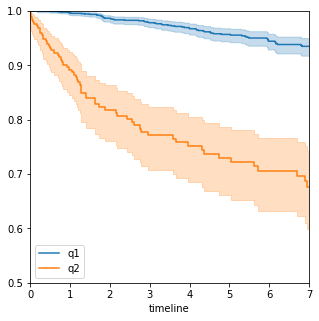

In [47]:
print("Train eicu strata plot")
plt.rcParams['figure.figsize'] = [5, 5]
plt.xlim([0, 7])
plt.ylim([0.5, 1])
get_plot(new_tr)
plt.show()

Test eicu strata plot


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


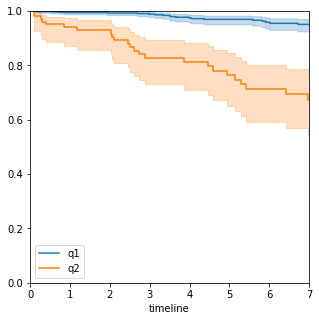

In [48]:
print("Test eicu strata plot")
plt.rcParams['figure.figsize'] = [5, 5]
plt.xlim([0, 7])
plt.ylim([0, 1])
get_plot(new_te_eicu)
plt.show()

Test mimic strata plot 


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


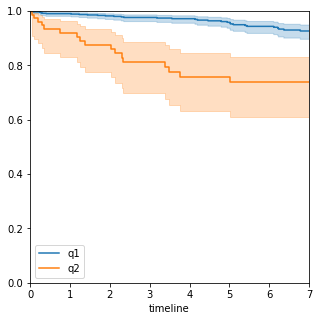

In [49]:
print("Test mimic strata plot ")
plt.rcParams['figure.figsize'] = [5, 5]
plt.xlim([0, 7])
plt.ylim([0, 1])
get_plot(new_te_mimic)
plt.show()

# Qualitative risk group comparison

In [60]:
pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', -1)
              
def get_strata_var(df, orig_df, orig_idxs):
    df = pd.concat([df[['risk', 'strata']].reset_index(drop=True), orig_df.iloc[orig_idxs, :].reset_index(drop=True)], axis=1)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    return df

def get_summary_stats(df):
    med = df.median(numeric_only=True)
    q1 = df.quantile([0.75], numeric_only=True)
    q3 = df.quantile([0.25], numeric_only=True)
    s = ''
    summaries = []
    for col in df.columns:
        if col not in med:
            cts = df[col].value_counts().to_dict()
            if col == 'gender':
                summaries.append('male: {}'.format(round(cts['Male'] / len(df), 3)))
            elif col == 'ethnicity':
                summaries.append('white: {}'.format(round(cts['Caucasian'] / len(df), 3)))
        else:
            summaries.append('{} ({} - {})'.format(round(med[col], 3), 
                                              round(q3[col].values[0], 3), round(q1[col].values[0], 3)))
    summ_df = pd.DataFrame({'Column': df.columns.tolist(), 'Median (IQR)': summaries})
    return summ_df

def get_merged_summary(grp_list, names):
    common_cols = set(grp_list[0].columns.tolist())
    for g in grp_list[1:]:
        common_cols = common_cols.intersection(g.columns.tolist())
    common_cols = list(set(common_cols))
    grp_list = [grp[common_cols] for grp in grp_list]
#     s1 = get_summary_stats(eicu_tr_grp1).to_dict()
#     s2 = get_summary_stats(eicu_tr_grp2).to_dict()
    merged = {}
    merged['Column'] = common_cols
    for (grp, name) in zip(grp_list, names):
        merged[name] = get_summary_stats(grp)['Median (IQR)'].tolist()
    return pd.DataFrame(merged)

eicu_tr = get_strata_var(new_X_train, eicu_tr_df, d['idxs_train'])
eicu_tr_grp1 = eicu_tr[eicu_tr['strata'] == 'q1'].drop('strata', axis=1)
eicu_tr_grp2 = eicu_tr[eicu_tr['strata'] == 'q2'].drop('strata', axis=1)

eicu_te = get_strata_var(new_X_test_eicu, eicu_te_df, d['idxs_test_eicu'])
eicu_te_grp1 = eicu_te[eicu_te['strata'] == 'q1'].drop('strata', axis=1)
eicu_te_grp2 = eicu_te[eicu_te['strata'] == 'q2'].drop('strata', axis=1)

mimic_te = get_strata_var(new_X_test_mimic, mimic_df, d['idxs_test_mimic'])
mimic_te_grp1 = mimic_te[mimic_te['strata'] == 'q1'].drop('strata', axis=1)
mimic_te_grp2 = mimic_te[mimic_te['strata'] == 'q2'].drop('strata', axis=1)

eviral_te = get_strata_var(new_X_test_eviral, eviral_df, d['idxs_eicu_viral'])
mviral_te = get_strata_var(new_X_test_mviral, mviral_df, d['idxs_mimic_viral'])

group_list = [eicu_tr_grp1, eicu_tr_grp2, 
              eicu_te_grp1, eicu_te_grp2,
              mimic_te_grp1, mimic_te_grp2]
names = [
    'eicu_tr_grp1', 'eicu_tr_grp2', 
    'eicu_te_grp1', 'eicu_te_grp2',
    'mimic_te_grp1', 'mimic_te_grp2'
]
get_merged_summary(group_list, names)


/opt/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Column,eicu_tr_grp1,eicu_tr_grp2,eicu_te_grp1,eicu_te_grp2,mimic_te_grp1,mimic_te_grp2
0,ast,28.0 (18.0 - 53.0),57.0 (25.0 - 163.0),30.0 (19.0 - 51.0),41.0 (22.0 - 118.0),34.0 (21.0 - 64.0),68.0 (39.0 - 153.0)
1,heart_rate,88.0 (76.0 - 100.0),100.0 (89.0 - 112.0),87.0 (75.0 - 98.0),103.0 (95.0 - 110.75),89.0 (78.0 - 104.0),100.0 (84.0 - 116.0)
2,deceased_indicator,0.0 (0.0 - 0.0),0.0 (0.0 - 1.0),0.0 (0.0 - 0.0),0.0 (0.0 - 1.0),0.0 (0.0 - 0.0),0.0 (0.0 - 1.0)
3,respiratory_rate,20.0 (17.0 - 25.0),22.0 (17.0 - 26.75),20.0 (16.0 - 25.0),21.0 (16.0 - 25.25),20.0 (16.0 - 24.0),20.0 (17.0 - 26.0)
4,censor_or_deceased_days,2.712 (1.005 - 6.639),2.931 (1.07 - 7.651),2.832 (1.019 - 6.344),3.923 (1.906 - 10.756),3.357 (1.093 - 8.296),5.307 (1.89 - 11.477)
5,albumin,2.7 (2.2 - 3.2),2.3 (1.9 - 2.7),2.6 (2.2 - 3.2),2.3 (1.8 - 2.8),3.05 (2.6 - 3.5),2.8 (2.275 - 3.2)
6,sodium,139.0 (136.0 - 142.0),139.0 (135.0 - 142.0),139.0 (136.5 - 142.0),139.0 (136.0 - 143.0),139.0 (136.0 - 142.0),137.0 (134.0 - 141.25)
7,potassium,3.9 (3.6 - 4.3),4.1 (3.6 - 4.6),3.9 (3.6 - 4.3),4.15 (3.8 - 4.675),3.9 (3.6 - 4.3),4.05 (3.5 - 4.4)
8,total_protein,6.0 (5.4 - 6.7),5.5 (4.9 - 6.2),6.0 (5.4 - 6.7),5.35 (4.7 - 6.15),6.15 (5.325 - 7.1),5.9 (4.9 - 6.8)
9,eosinophils,0.1 (0.0 - 1.0),0.0 (0.0 - 1.0),0.2 (0.0 - 1.225),0.0 (0.0 - 1.0),0.4 (0.0 - 1.3),0.2 (0.0 - 0.7)


In [114]:
eicu_tr.to_csv('../data/new_X_train.csv', index=False)
eicu_te.to_csv('../data/new_X_test_eicu.csv', index=False)
mimic_te.to_csv('../data/new_X_test_mimic.csv', index=False)
eviral_te.to_csv('../data/new_X_eicu_viral.csv', index=False)
mviral_te.to_csv('../data/new_X_mimic_viral.csv', index=False)

# Bootstrapped concordances (95% CI) for all the comparison risk scores

In [119]:
r_eicu_tr = get_r_df(eicu_tr)
r_eicu_te = get_r_df(eicu_te)
r_mimic_te = get_r_df(mimic_te)

def get_curb65(df):
    result = r_risk_scores.curb65(get_r_df(df))
    result = result.rx2("curb65")
    return (-np.array(result)).tolist()

def get_psiport(df):
    result = r_risk_scores.psiport(get_r_df(df))
    result = result.rx2("psiport")
    return (-np.array(result)).tolist()

def get_smartcop(df):
    result = r_risk_scores.smartcop(get_r_df(df))
    result = result.rx2("smartcop")
    return (-np.array(result)).tolist()

def get_maastricht(df):
    result = r_risk_scores.maastricht(get_r_df(df))
    result = result.rx2("maastricht")
    return (-np.array(result)).tolist()

def get_risk_scores(df, clean_df, cph):
    cph_preds = -cph.predict_partial_hazard(clean_df)
    cph_preds = cph_preds.tolist()
    risks = {
        'cph': cph_preds,
        'curb65': get_curb65(df),
        'psiport': get_psiport(df),
        'smartcop': get_smartcop(df),
        'maastricht': get_maastricht(df),
    }
    return risks

def get_bootstrapped_risk_scores(df, clean_df, y, cph, n_replicates=1000, tails=0.05):
    all_preds = get_risk_scores(df, clean_df, cph)
    scores = {}
    for seed in range(n_replicates):
        for (name, preds) in all_preds.items():
            resampled = resample(y[duration_col].tolist(), 
                                 preds, 
                                 y[event_col].tolist(), 
                                 n_samples=len(y), 
                                 random_state=seed)
            T, pred, E = resampled
            ci = concordance_index(T, pred, E)
            scores[name] = scores.get(name, []) + [ci]
    score_stats = {}
    for (name, s) in scores.items():
        median = np.median(s)
        q_lower = np.quantile(s, tails/2.0)
        q_upper = np.quantile(s, 1.0 - tails/2.0)
        score_stats[name] = (median, q_lower, q_upper)
    return score_stats, scores

eviral_te = get_strata_var(new_X_test_eviral, eviral_df, d['idxs_eicu_viral'])
mviral_te = get_strata_var(new_X_test_mviral, mviral_df, d['idxs_mimic_viral'])
rerun = True
tails = 0.05

if rerun:
    print('eicu tr...')
    tr_score_stats, tr_all_risk_scores = get_bootstrapped_risk_scores(eicu_tr, X_tr, y_tr, best_cph,
                                                                      n_replicates=1000, tails=0.05)
    
    print('eicu te...')
    te_eicu_score_stats, te_eicu_all_risk_scores = get_bootstrapped_risk_scores(eicu_te, X_te_eicu, y_te_eicu, best_cph,
                                                                                n_replicates=1000, tails=0.05)
    
    print('mimic te...')
    te_mimic_score_stats, te_mimic_all_risk_scores = get_bootstrapped_risk_scores(mimic_te, X_te_mimic, y_te_mimic, best_cph,
                                                                                  n_replicates=1000, tails=0.05)
    all_risk_scores = {
    'tr_eicu_risks': tr_all_risk_scores,
    'te_eicu_risks': te_eicu_all_risk_scores,
    'te_mimic_risks': te_mimic_all_risk_scores,
    }

    all_risk_stats = {
        'tr_eicu_risks': tr_score_stats,
        'te_eicu_risks': te_eicu_score_stats,
        'te_mimic_risks': te_mimic_score_stats,
    }

    with open('../results/all_risk_scores2.pkl', 'wb') as fout:
        pickle.dump(all_risk_scores, fout)
else:
    with open('../results/all_risk_scores.pkl', 'rb') as fin:
        all_risk_scores = pickle.load(fin)
    all_risk_stats = {}
    for (dataname, scores) in all_risk_scores.items():
        score_stats = {}
        for (name, s) in scores.items():
            median = np.median(s)
            q_lower = np.quantile(s, tails/2.0)
            q_upper = np.quantile(s, 1.0 - tails/2.0)
            score_stats[name] = (median, q_lower, q_upper)
        all_risk_stats[dataname] = score_stats       
        

In [205]:
for dataname, score_stats in all_risk_stats.items():
    print('dataname: {}'.format(dataname))
    for (name, stats) in score_stats.items():
        tabs = '\t' if len(name) < 7 else ''
        print('{}:\t{}{} ({} - {})'.format(name, tabs, 
                                           round(stats[0], 3), 
                                           round(stats[1], 3), 
                                           round(stats[2], 3)))

dataname: tr_eicu_risks
cph:		0.766 (0.719 - 0.812)
curb65:		0.659 (0.611 - 0.704)
psiport:	0.708 (0.663 - 0.756)
smartcop:	0.688 (0.641 - 0.733)
maastricht:	0.675 (0.63 - 0.714)
dataname: te_eicu_risks
cph:		0.77 (0.689 - 0.832)
curb65:		0.623 (0.553 - 0.692)
psiport:	0.709 (0.632 - 0.78)
smartcop:	0.733 (0.671 - 0.795)
maastricht:	0.618 (0.537 - 0.697)
dataname: te_mimic_risks
cph:		0.654 (0.567 - 0.738)
curb65:		0.593 (0.518 - 0.66)
psiport:	0.621 (0.545 - 0.689)
smartcop:	0.659 (0.589 - 0.721)
maastricht:	0.576 (0.497 - 0.661)
